In [49]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm
from dPCA import dPCA



mpl.rcdefaults()
#mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
#mpl.rcParams.update(mpl_config)

## Data import

In [50]:
import pandas as pd

root_directory_base = '/auto/data6/eTheremin/'

sheet_ids = {
    "NAPOLEON": "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU",
    "HERCULE": "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU", 
    "MMELOIK": "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU", 
    "ALTAI": "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU", 
}

all_sessions = []

for sheet_name, sheet_id in sheet_ids.items():
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)

    root_directory = f'/auto/data2/eTheremin/{sheet_name}/'
    
    # Filtrer les sessions "use" == yes et type "playback"
    filtered_sessions = df[(df['use'] == 'yes')& (df['type'] == 'playback')]

    # Définir les headstages selon la règle
    headstages = [0] if sheet_name == "HERCULE" else [0, 1]
    headstages = [0] if sheet_name == "FRINAULT" else [0, 1]

    for headstage in headstages:
        all_sessions.append({
            'sheet_name': sheet_name,
            'headstage': headstage,
            'sessions': (root_directory + filtered_sessions['session']).tolist(),
            'sessions_type': filtered_sessions['type'].tolist()
            #'timeline': filtered_sessions['timeline'].tolist()  # <-- nouvelle colonne
        })

# Exemple d'accès :
for entry in all_sessions:
    print(entry['sheet_name'], "HS", entry['headstage'], "→", len(entry['sessions'])) #, "timelines:", entry['timeline'])




NAPOLEON HS 0 → 14
NAPOLEON HS 1 → 14
HERCULE HS 0 → 12
HERCULE HS 1 → 12
MMELOIK HS 0 → 17
MMELOIK HS 1 → 17
ALTAI HS 0 → 3
ALTAI HS 1 → 3


In [51]:
all_sessions_paths = []
all_sessions_types = []

for sheet_name, sheet_id in sheet_ids.items():
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)

    #filtered_sessions = df[(df['use'] == 'yes') & (df['type'].isin(['playback_block', 'playback']))]
    filtered_sessions = df[(df['use'] == 'yes') & (df['type'] == 'playback')]
    #filtered_sessions = df[(df['use'] == 'yes') & (df['type'] =='playback') & (df['timeline'] =='expert')]

    sessions = filtered_sessions['session'].tolist()
    #types = filtered_sessions['timeline'].tolist()  # récupérer les types

    # règle headstage : HERCULE => seulement 0, sinon 0 et 1
    if sheet_name == "HERCULE":
        root_directory = f'/auto/data6/eTheremin/{sheet_name}/'
        headstages = [0]


    elif sheet_name == "ALTAI":
        root_directory = f'/auto/data2/eTheremin/{sheet_name}/'
        headstages = [0]
    else:
        root_directory = f'/auto/data6/eTheremin/{sheet_name}/'
        headstages = [0, 1]

    # construction des chemins avec headstage à la fin
    for s in sessions :#:zip(sessions):#, types):
        for hs in headstages:
            session_path = f"{root_directory}{s}/headstage_{hs}/"
            all_sessions_paths.append(session_path)
            #all_sessions_types.append(t)  # ajouter le type correspondant

print("Nombre total de sessions :", len(all_sessions_paths))


Nombre total de sessions : 77


In [52]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y

os.chdir('/auto/data6/eTheremin/')


    
files = all_sessions_paths

n_data_s = []
f_data_s = []
for file in tqdm(files) :
    try :
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        n_data = np.load(file+'data_0.005.npy', allow_pickle=True)
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        gc = np.load(file+'good_clusters.npy')
    
        f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}
    
        for item in f_data:
            for key, value in item.items():
                f_data_dict[key].append(value)

        f_data = pd.DataFrame(f_data_dict)
        f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
        f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())

        n_data = n_data[gc,:].astype(float)
        #n_data=n_data.astype(float)
    
        n_data_s.append(n_data)
        f_data_s.append(f_data)
        
    except :
        print('Error when building dataframe for file :' + str(file))

os.chdir('/auto/data6/eTheremin/Analysis')

  0%|          | 0/77 [00:00<?, ?it/s]

Error when building dataframe for file :/auto/data6/eTheremin/NAPOLEON/NAPOLEON_20250110_SESSION_00/headstage_0/
Error when building dataframe for file :/auto/data6/eTheremin/NAPOLEON/NAPOLEON_20250110_SESSION_00/headstage_1/
Error when building dataframe for file :/auto/data6/eTheremin/MMELOIK/MMELOIK_20241205_SESSION_01/headstage_0/
Error when building dataframe for file :/auto/data6/eTheremin/MMELOIK/MMELOIK_20241205_SESSION_01/headstage_1/
Error when building dataframe for file :/auto/data2/eTheremin/ALTAI/ALTAI_20240902_SESSION_00/headstage_0/


In [5]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_s))) :
    n_data_smooth = gaussian_filter(n_data_s[i],sigma=3,axes=1) # sigma = 10
    # je teste de retirer la moyenne de la ligne à la ligne en question
    n_data_smooth = n_data_smooth - n_data_smooth.mean(axis=1, keepdims=True)
    n_data_s[i] = n_data_smooth

  0%|          | 0/72 [00:00<?, ?it/s]

In [6]:
num_nans = sum(np.isnan(x) for row in n_data_s for x in row if isinstance(x, float))
print(num_nans)


0


In [7]:
import numpy as np

# Convertir la liste de tableaux en un tableau NumPy d'objets
n_data_s_array = np.array(n_data_s, dtype=object)
f_data_s_array = np.array(f_data_s, dtype=object)
# Sauvegarder
#np.save( "/auto/data6/eTheremin/Analysis/n_data_s.npy", n_data_s_array)
#np.save( "/auto/data6/eTheremin/Analysis/f_data_s.npy", f_data_s_array)


In [8]:
#load data:
#n_data_s = np.load("/auto/data6/eTheremin/Analysis/n_data_s.npy", allow_pickle=True)
#f_data_s = np.load("/auto/data6/eTheremin/Analysis/f_data_s.npy", allow_pickle=True)

In [9]:

def moving_average(data, window_size):
    # Calculer la moyenne mobile avec remplissage
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')


In [10]:
# le plus simple c'est d'ajouter la vitesse a f_data:

speed_bins_dict = {
    '0': (0, 4),
    '10': (10, 30),
    '100': (30, 200),
    '200': (200, np.inf)
}

# Convertir le dict en deux listes pour pandas.cut
bin_labels = list(speed_bins_dict.keys())
bin_edges = [v[0] for v in speed_bins_dict.values()] + [list(speed_bins_dict.values())[-1][1]]

        
for features in f_data_s:
    print(type(features))
    
    unique_tones = np.unique(np.array(features['Played_frequency']))
    pixels = np.linspace(0, 28, len(unique_tones))        # 28 cm
    freq_to_pixel = {tone: pixel for tone, pixel in zip(unique_tones, pixels)} # tableau de correspondance des fréquences en pixels

    f_tr = features.loc[features["Condition"] == 0, "Played_frequency"].to_numpy()
    f_pb = features.loc[features["Condition"] == 1, "Mock_frequency"].to_numpy()

    f_tot = np.append(f_tr, f_pb)

    f_to_pixels = np.array([freq_to_pixel.get(f, np.nan) for f in f_tot])

    speed_x = np.diff(moving_average(f_to_pixels, window_size=50))
    speed_x = np.append(0, speed_x[0:])
    speed_x = np.abs(speed_x)*1000
    features["Speed_x"] = speed_x

    features["Speed_bin"] = pd.cut(features["Speed_x"], 
                                   bins=bin_edges, 
                                   labels=bin_labels, 
                                   include_lowest=True, right=False)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pand

In [11]:
np.unique(features["Speed_bin"].dropna())


array(['0', '10', '100', '200'], dtype=object)

## Analysis A1

In [12]:
f_min, f_max = 1000, 5000

In [13]:
#version avec psth espacés dans le temps : 
def get_index_freq_speed(data, features, freq, speed_bin, t_pre=0.06, t_post=0.5, condition="playback",
                        min_distance_ms=50, bin_width=0.005):
    """
    Calcul du PSTH pour chaque neurone autour des changements de fréquence,
    en ne conservant que les triggers espacés d'au moins min_distance_ms 
    depuis le trigger précédent (ce qu'il se passe après importe peu).
    """
    condition_map = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}
    c = condition_map.get(condition, 1)

    psth = []

    # Sélection des triggers
    if condition in ["tracking", "playback"]:
        trigger_mask = (
            (features['Frequency_changes'] > 0) &
            (features['Condition'] == c) &
            (features['Played_frequency'] == freq) & 
            (features['Speed_bin'] == speed_bin) 

        )
    else:
        trigger_mask = (features['Frequency_changes'] > 0) & (features['Condition'] == c)

    trigger_indices = features.index[trigger_mask].to_numpy()

    # Filtrage : distance minimale avec le trigger précédent uniquement
    min_distance_bins = int((min_distance_ms / 1000) / bin_width)
    if len(trigger_indices) > 0:
        filtered_indices = [trigger_indices[0]]
        for idx in trigger_indices[1:]:
            if idx - filtered_indices[-1] >= min_distance_bins:
                filtered_indices.append(idx)
        trigger_indices = np.array(filtered_indices)

    n_bins_pre = int(t_pre / bin_width)
    n_bins_post = int(t_post / bin_width)
    n_bins = n_bins_pre + n_bins_post

    # Calcul du PSTH
    for cluster_data in data:
        cluster_psth = []
        for idx in trigger_indices:
            start = max(idx - n_bins_pre, 0)
            end = min(idx + n_bins_post, len(cluster_data))
            segment = cluster_data[start:end]

            # Padding si segment trop court
            pad_left = max(0, n_bins_pre - (idx - start))
            pad_right = max(0, n_bins_post - (end - idx))
            segment = np.pad(segment, (pad_left, pad_right), mode='constant', constant_values=np.nan)

            cluster_psth.append(segment)
        psth.append(cluster_psth)

    return trigger_indices, psth



def get_psth_by_freq_speed(data, features, speed_bin, condition, t_pre=0.2, t_post=0.3, bin_width=0.005, min_distance_ms = 50):
    """
    Calcule les PSTH moyens par cluster pour chaque fréquence.
    
    Inputs:
        - data : liste ou array [n_clusters x T]
        - features : DataFrame avec 'Frequency_changes', 'Condition', 'Played_frequency'
        - condition : 'tracking', 'playback', 'tail', 'mapping change'
        - t_pre, t_post : temps avant et après le trigger (s)
        - dt : durée d’un point dans data (s)
    
    Output:
        - psth_dict : dictionnaire freq -> array (n_clusters x n_bins)
    """
    n_clusters = len(data)
    all_frequencies = np.unique(features['Played_frequency'])
    frequencies = all_frequencies[(all_frequencies >= 1000) & (all_frequencies <= 5000)]
    n_bins = int((t_pre + t_post) / bin_width)

    psth_dict = {}
    for freq in frequencies:
        trigger_indices, psth_per_cluster = get_index_freq_speed(
            data, features, freq, speed_bin, t_pre=t_pre, t_post=t_post, condition=condition, min_distance_ms = min_distance_ms, bin_width=bin_width)

        psth_array = np.full((n_clusters, n_bins), np.nan)
        for i, cluster_psth in enumerate(psth_per_cluster):
            if len(cluster_psth) > 0:
                psth_array[i] = np.nanmean(cluster_psth, axis=0)

        psth_dict[freq] = psth_array

    return psth_dict



In [14]:
for features in f_data_s:
    features["Speed_bin"] = features["Speed_bin"].cat.add_categories("inf")  # ajoute la catégorie "0" si pas déjà là
    features["Speed_bin"] = features["Speed_bin"].fillna("inf")

In [15]:
t_pre, t_post, bin_width = 0.2, 0.3, 0.005

speed_bins = np.unique(f_data_s[0]["Speed_bin"])    
#all_traj_track, all_traj_pb = [], []
all_traj_track_0, all_traj_pb_0 = [], []
all_traj_track_1, all_traj_pb_1 = [], []
all_traj_track_2, all_traj_pb_2 = [], []
all_traj_track_3, all_traj_pb_3 = [], []

for n_data, f_data in tqdm(zip(n_data_s, f_data_s), total=len(n_data_s), desc="Processing datasets"):

    track_0 = get_psth_by_freq_speed(n_data, f_data, speed_bins[0], 'tracking', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
    pb_0= get_psth_by_freq_speed(n_data, f_data, speed_bins[0], 'playback', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)

    track_1 = get_psth_by_freq_speed(n_data, f_data, speed_bins[1], 'tracking', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
    pb_1 = get_psth_by_freq_speed(n_data, f_data, speed_bins[1], 'playback', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)

    track_2 = get_psth_by_freq_speed(n_data, f_data, speed_bins[2], 'tracking', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
    pb_2 = get_psth_by_freq_speed(n_data, f_data, speed_bins[2], 'playback', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)

    track_3 = get_psth_by_freq_speed(n_data, f_data, speed_bins[3], 'tracking', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
    pb_3 = get_psth_by_freq_speed(n_data, f_data, speed_bins[3], 'playback', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
        
    all_traj_track_0.append(track_0)
    all_traj_pb_0.append(pb_0)

    all_traj_track_1.append(track_1)
    all_traj_pb_1.append(pb_1)

    all_traj_track_2.append(track_2)
    all_traj_pb_2.append(pb_2)

    all_traj_track_3.append(track_3)
    all_traj_pb_3.append(pb_3)



Processing datasets:   0%|          | 0/72 [00:00<?, ?it/s]

In [16]:
all_traj_track_clean = {}
all_traj_pb_clean = {}

for i in range(4):  # de 0 à 3
    track_list = globals()[f"all_traj_track_{i}"]
    pb_list = globals()[f"all_traj_pb_{i}"]

    clean_track, clean_pb = [], []

    for track, pb in tqdm(zip(track_list, pb_list),
                          total=len(track_list),
                          desc=f"Filtering NaNs (bin {i})"):
        has_nan = any(np.isnan(arr).any() for arr in track.values()) or \
                  any(np.isnan(arr).any() for arr in pb.values())
        if not has_nan:
            clean_track.append(track)
            clean_pb.append(pb)

    all_traj_track_clean[i] = clean_track
    all_traj_pb_clean[i] = clean_pb

    print(f"Bin {i} → conservés : {len(clean_track)} / {len(track_list)}")
    
all_traj_pb_0_clean = all_traj_pb_clean[0]
all_traj_pb_1_clean = all_traj_pb_clean[1]
all_traj_pb_2_clean = all_traj_pb_clean[2]
#all_traj_pb_3_clean = all_traj_pb_clean[3]

all_traj_track_0_clean = all_traj_track_clean[0]
all_traj_track_1_clean = all_traj_track_clean[1]
all_traj_track_2_clean = all_traj_track_clean[2]

all_track = {}
all_pb = {}

for i in range(3):  # bins 0 à 3
    track_clean = globals()[f"all_traj_track_{i}_clean"]
    pb_clean = globals()[f"all_traj_pb_{i}_clean"]

    all_track[i] = []
    all_pb[i] = []

    # Transposer tracking
    for session_dict in track_clean:
        transposed_dict = {k: v.T for k, v in session_dict.items()}
        all_track[i].append(transposed_dict)

    # Transposer playback
    for session_dict in pb_clean:
        transposed_dict = {k: v.T for k, v in session_dict.items()}
        all_pb[i].append(transposed_dict)

    print(f"Bin {i} → {len(all_track[i])} sessions track, {len(all_pb[i])} sessions pb")

Filtering NaNs (bin 0):   0%|          | 0/72 [00:00<?, ?it/s]

Bin 0 → conservés : 72 / 72


Filtering NaNs (bin 1):   0%|          | 0/72 [00:00<?, ?it/s]

Bin 1 → conservés : 72 / 72


Filtering NaNs (bin 2):   0%|          | 0/72 [00:00<?, ?it/s]

Bin 2 → conservés : 71 / 72


Filtering NaNs (bin 3):   0%|          | 0/72 [00:00<?, ?it/s]

Bin 3 → conservés : 5 / 72
Bin 0 → 72 sessions track, 72 sessions pb
Bin 1 → 72 sessions track, 72 sessions pb
Bin 2 → 71 sessions track, 71 sessions pb


In [17]:
from collections import defaultdict
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = defaultdict(list)

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df


traj_df_track_0, traj_df_pb_0 = pseudo_trajectories(all_track[0]), pseudo_trajectories(all_pb[0])
traj_df_track_1, traj_df_pb_1 = pseudo_trajectories(all_track[1]), pseudo_trajectories(all_pb[1])
traj_df_track_2, traj_df_pb_2 = pseudo_trajectories(all_track[2]), pseudo_trajectories(all_pb[2])

# Liste des matrices


In [18]:
traj_mats_speed = [
    np.stack(traj_df_track_0['trajectory']),
    np.stack(traj_df_track_1['trajectory']),
    np.stack(traj_df_track_2['trajectory']),
    np.stack(traj_df_pb_0['trajectory']),
    np.stack(traj_df_pb_1['trajectory']),
    np.stack(traj_df_pb_2['trajectory']),
]

# Trouver la taille la plus fréquente sur la dimension 2
sizes_dim2 = [mat.shape[2] for mat in traj_mats_speed]
from collections import Counter
most_common_size = Counter(sizes_dim2).most_common(1)[0][0]

# Identifier les sessions problématiques
bad_indices = [i for i, mat in enumerate(traj_mats_speed) if mat.shape[2] != most_common_size]
print("Sessions à retirer :", bad_indices)



# Liste des indices valides pour chaque matrice (neurones présents)
valid_neurons_sets = [set(range(mat.shape[2])) for mat in traj_mats_speed]

# Si toutes les matrices ont exactement les mêmes indices, ok
# Sinon, on ne garde que les indices communs à toutes
common_neurons = set.intersection(*valid_neurons_sets)
print(f"Nombre de neurones communs à toutes les sessions : {len(common_neurons)}")
# Convertir en liste triée pour conserver l'ordre
common_neurons = sorted(common_neurons)

# Garder seulement les neurones valides dans chaque matrice
traj_mats_clean = [mat[:, :, common_neurons] for mat in traj_mats_speed]


# Concaténer
#traj_mat_speed_all = np.concatenate(traj_mats_clean, axis=0)


def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std



# Sélectionner uniquement track_0 et pb_0
traj_mats_0 = [traj_mats_clean[0], traj_mats_clean[3]]
traj_mats_1 = [traj_mats_clean[1], traj_mats_clean[4]]
traj_mats_2 = [traj_mats_clean[2], traj_mats_clean[5]]

# Concaténer les sessions
traj_mat_0_all = np.concatenate(traj_mats_0, axis=0)
traj_mat_1_all = np.concatenate(traj_mats_1, axis=0)
traj_mat_2_all = np.concatenate(traj_mats_2, axis=0)
print("Shape finale (track_0 + pb_0) :", traj_mat_0_all.shape)


# Flatten for PCA
#n_samples, n_time, n_features = traj_mat_speed_all.shape
#traj_mat_speed_flat = standardize(traj_mat_speed_all.reshape(n_samples * n_time, n_features))


Sessions à retirer : [2, 5]
Nombre de neurones communs à toutes les sessions : 1344
Shape finale (track_0 + pb_0) : (22, 100, 1344)


maintenant je fais tout pareil mais sans faire la distinction par vitesse (pca la dessus)

In [19]:
#version avec psth espacés dans le temps : 
def get_index_freq(data, features, freq, t_pre=0.2, t_post=0.3, condition="playback",
                        min_distance_ms=50, bin_width=0.005):
    """
    Calcul du PSTH pour chaque neurone autour des changements de fréquence,
    en ne conservant que les triggers espacés d'au moins min_distance_ms 
    depuis le trigger précédent (ce qu'il se passe après importe peu).
    """
    condition_map = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}
    c = condition_map.get(condition, 1)

    psth = []

    # Sélection des triggers
    if condition in ["tracking", "playback"]:
        trigger_mask = (
            (features['Frequency_changes'] > 0) &
            (features['Condition'] == c) &
            (features['Played_frequency'] == freq)

        )
    else:
        trigger_mask = (features['Frequency_changes'] > 0) & (features['Condition'] == c)

    trigger_indices = features.index[trigger_mask].to_numpy()

    # Filtrage : distance minimale avec le trigger précédent uniquement
    min_distance_bins = int((min_distance_ms / 1000) / bin_width)
    if len(trigger_indices) > 0:
        filtered_indices = [trigger_indices[0]]
        for idx in trigger_indices[1:]:
            if idx - filtered_indices[-1] >= min_distance_bins:
                filtered_indices.append(idx)
        trigger_indices = np.array(filtered_indices)

    n_bins_pre = int(t_pre / bin_width)
    n_bins_post = int(t_post / bin_width)
    n_bins = n_bins_pre + n_bins_post

    # Calcul du PSTH
    for cluster_data in data:
        cluster_psth = []
        for idx in trigger_indices:
            start = max(idx - n_bins_pre, 0)
            end = min(idx + n_bins_post, len(cluster_data))
            segment = cluster_data[start:end]

            # Padding si segment trop court
            pad_left = max(0, n_bins_pre - (idx - start))
            pad_right = max(0, n_bins_post - (end - idx))
            segment = np.pad(segment, (pad_left, pad_right), mode='constant', constant_values=np.nan)

            cluster_psth.append(segment)
        psth.append(cluster_psth)

    return trigger_indices, psth



def get_psth_by_freq(data, features, condition, t_pre, t_post, bin_width=0.005, min_distance_ms = 50):
    """
    Calcule les PSTH moyens par cluster pour chaque fréquence.
    
    Inputs:
        - data : liste ou array [n_clusters x T]
        - features : DataFrame avec 'Frequency_changes', 'Condition', 'Played_frequency'
        - condition : 'tracking', 'playback', 'tail', 'mapping change'
        - t_pre, t_post : temps avant et après le trigger (s)
        - dt : durée d’un point dans data (s)
    
    Output:
        - psth_dict : dictionnaire freq -> array (n_clusters x n_bins)
    """
    n_clusters = len(data)
    all_frequencies = np.unique(features['Played_frequency'])
    frequencies = all_frequencies[(all_frequencies >= 1000) & (all_frequencies <= 5000)]
    n_bins = int((t_pre + t_post) / bin_width)

    psth_dict = {}
    for freq in frequencies:
        trigger_indices, psth_per_cluster = get_index_freq(
            data, features, freq, t_pre=t_pre, t_post=t_post, condition=condition, min_distance_ms = min_distance_ms, bin_width=bin_width)

        psth_array = np.full((n_clusters, n_bins), np.nan)
        for i, cluster_psth in enumerate(psth_per_cluster):
            if len(cluster_psth) > 0:
                psth_array[i] = np.nanmean(cluster_psth, axis=0)

        psth_dict[freq] = psth_array

    return psth_dict

In [20]:
all_traj_track, all_traj_pb = [], []

for n_data, f_data in tqdm(zip(n_data_s, f_data_s), total=len(n_data_s), desc="Processing datasets"):

    track = get_psth_by_freq(n_data, f_data, 'tracking', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
    pb = get_psth_by_freq(n_data, f_data, 'playback', t_pre, t_post, bin_width=0.005, min_distance_ms = 50)
        
    all_traj_track.append(track)
    all_traj_pb.append(pb)

all_traj_track_clean, all_traj_pb_clean = [], []

for track, pb in tqdm(zip(all_traj_track, all_traj_pb), total=len(all_traj_track), desc="Filtering NaNs"):
    # Vérifier s'il y a un NaN dans track ou pb
    has_nan = any(np.isnan(arr).any() for arr in track.values()) or any(np.isnan(arr).any() for arr in pb.values())
    
    if not has_nan:
        all_traj_track_clean.append(track)
        all_traj_pb_clean.append(pb)

all_track, all_pb = [], []

for session_dict in all_traj_track_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_track.append(transposed_dict)


for session_dict in all_traj_pb_clean:
    # créer un nouveau dictionnaire pour cette session
    transposed_dict = {}
    for key, array in session_dict.items():
        transposed_dict[key] = array.T  # transpose le tableau
    all_pb.append(transposed_dict)

traj_df_track, traj_df_pb = pseudo_trajectories(all_track), pseudo_trajectories(all_pb)

Processing datasets:   0%|          | 0/72 [00:00<?, ?it/s]

Filtering NaNs:   0%|          | 0/72 [00:00<?, ?it/s]

In [22]:
# Stack trajectories

from sklearn.decomposition import PCA

original_traj_mats = [
    np.stack(traj_df_track['trajectory']),
    np.stack(traj_df_pb['trajectory']),

]

original_traj_mats_clean = [mat[:, :, common_neurons] for mat in original_traj_mats]


# Concatenate all trajectory matrices
original_traj_mat_all = np.concatenate(original_traj_mats_clean, axis=0)

# Flatten for PCA
n_samples, n_time, n_features = original_traj_mat_all.shape
original_traj_mat_flat = standardize(original_traj_mat_all.reshape(n_samples * n_time, n_features))
print("Shape finale :", original_traj_mat_all.shape)
# PCA
n_comp = 10

import joblib
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(original_traj_mat_flat)

Shape finale : (22, 100, 1344)


In [25]:
# Save PCA model
import joblib
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(original_traj_mat_flat)

#joblib.dump(pca_all, "/auto/data6/eTheremin/Analysis/pca_model_felicie.pkl")

In [26]:

# Reshape back to original time structure
traj_PC_all = traj_PC_all_flat.reshape(n_samples, n_time, n_comp)

#Split back into groups
nb_freq = original_traj_mats[0].shape[0]
traj_PC_track, traj_PC_pb = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(original_traj_mats))
]

In [53]:
#projeter les données de la PCA dans l'espace des PC sans utiliser fit_transform
n_samples, n_time, n_features = original_traj_mat_all.shape
traj_mat_original_flat = standardize(original_traj_mat_all.reshape(n_samples * n_time, n_features))
print("Shape aplatie :", traj_mat_original_flat.shape)

# Centrer les données par rapport à la moyenne de la PCA originale
traj_mat_original_flat_centered = traj_mat_original_flat - pca_all.mean_  # shape = (n_samples_new, n_features)

# Multiplication par la matrice des composantes principales
traj_PC_original = traj_mat_original_flat_centered @ pca_all.components_.T  # shape = (n_samples_new, n_components)
traj_PC_original.shape

# Reshape back to original time structure
traj_PC_original = traj_PC_original.reshape(n_samples, n_time, n_comp)

#Split back into groups
nb_freq = traj_mats_0[0].shape[0]
traj_PC_track_original, traj_PC_pb_original = [
    traj_PC_original[i * nb_freq:(i + 1) * nb_freq] for i in range(len(original_traj_mats))
]
# comparer la projection de traj_PC_track avec traj_PC_track_original et traj_PC_pb avec traj_PC_pb_original


Shape aplatie : (2200, 1344)


utiliser les données avec vitesse et les projeter dans l'espace de la PCA globale 

In [28]:
n_samples, n_time, n_features = traj_mat_0_all.shape
traj_mat_0_flat = standardize(traj_mat_0_all.reshape(n_samples * n_time, n_features))
print("Shape aplatie :", traj_mat_0_flat.shape)

# Centrer les données par rapport à la moyenne de la PCA originale
traj_mat_0_flat_centered = traj_mat_0_flat - pca_all.mean_  # shape = (n_samples_new, n_features)

# Multiplication par la matrice des composantes principales
traj_PC_0 = traj_mat_0_flat_centered @ pca_all.components_.T  # shape = (n_samples_new, n_components)
traj_PC_0.shape

# Reshape back to original time structure
traj_PC_0 = traj_PC_0.reshape(n_samples, n_time, n_comp)

#Split back into groups
nb_freq = traj_mats_0[0].shape[0]
traj_PC_track_0, traj_PC_pb_0 = [
    traj_PC_0[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats_0))
]


Shape aplatie : (2200, 1344)


In [29]:
n_samples, n_time, n_features = traj_mat_1_all.shape
traj_mat_1_flat = standardize(traj_mat_1_all.reshape(n_samples * n_time, n_features))
print("Shape aplatie :", traj_mat_1_flat.shape)

# Centrer les données par rapport à la moyenne de la PCA originale
traj_mat_1_flat_centered = traj_mat_1_flat - pca_all.mean_  # shape = (n_samples_new, n_features)

# Multiplication par la matrice des composantes principales
traj_PC_1 = traj_mat_1_flat_centered @ pca_all.components_.T  # shape = (n_samples_new, n_components)
traj_PC_1.shape

# Reshape back to original time structure
traj_PC_1 = traj_PC_1.reshape(n_samples, n_time, n_comp)

#Split back into groups
nb_freq = traj_mats_1[0].shape[0]
traj_PC_track_1, traj_PC_pb_1 = [
    traj_PC_1[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats_1))
]

Shape aplatie : (2200, 1344)


In [30]:
n_samples, n_time, n_features = traj_mat_2_all.shape
traj_mat_2_flat = standardize(traj_mat_2_all.reshape(n_samples * n_time, n_features))
print("Shape aplatie :", traj_mat_2_flat.shape)

# Centrer les données par rapport à la moyenne de la PCA originale
traj_mat_2_flat_centered = traj_mat_2_flat - pca_all.mean_  # shape = (n_samples_new, n_features)

# Multiplication par la matrice des composantes principales
traj_PC_2 = traj_mat_2_flat_centered @ pca_all.components_.T  # shape = (n_samples_new, n_components)
traj_PC_2.shape

# Reshape back to original time structure
traj_PC_2 = traj_PC_2.reshape(n_samples, n_time, n_comp)

#Split back into groups
nb_freq = traj_mats_2[0].shape[0]
traj_PC_track_2, traj_PC_pb_2 = [
    traj_PC_2[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats_2))
]

Shape aplatie : (2200, 1344)


Test dPCA

### Visualization

In [31]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)


def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8, show_plane=False,plane_color='grey', plane_alpha=0.1):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.
    Optionally show the 2D PCA plane of maximum variance in 3D case.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([interp_r(u_interp), interp_g(u_interp), interp_b(u_interp)], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)

    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)

        # Optionally draw 2D PCA plane
        if show_plane:
            pca = PCA(n_components=2)
            pca.fit(points)
            center = points.mean(axis=0)
            vecs = pca.components_
            # Create grid in PCA space
            grid_range = np.linspace(-1, 1, 10) * np.std(points, axis=0).max()
            Xg, Yg = np.meshgrid(grid_range, grid_range)
            plane_points = center + Xg[..., None] * vecs[0] + Yg[..., None] * vecs[1]
            ax.plot_surface(plane_points[..., 0], plane_points[..., 1], plane_points[..., 2],
                            color=plane_color, alpha=plane_alpha, linewidth=0, shade=False)


        return pca.components_

### Comparing Tracking vs Playback representations

/tmp/ipykernel_104685/3252307892.py:149: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)
/tmp/ipykernel_104685/3252307892.py:149: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)
/tmp/ipykernel_104685/3252307892.py:149: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)


Text(0, 0.5, 'PC3')

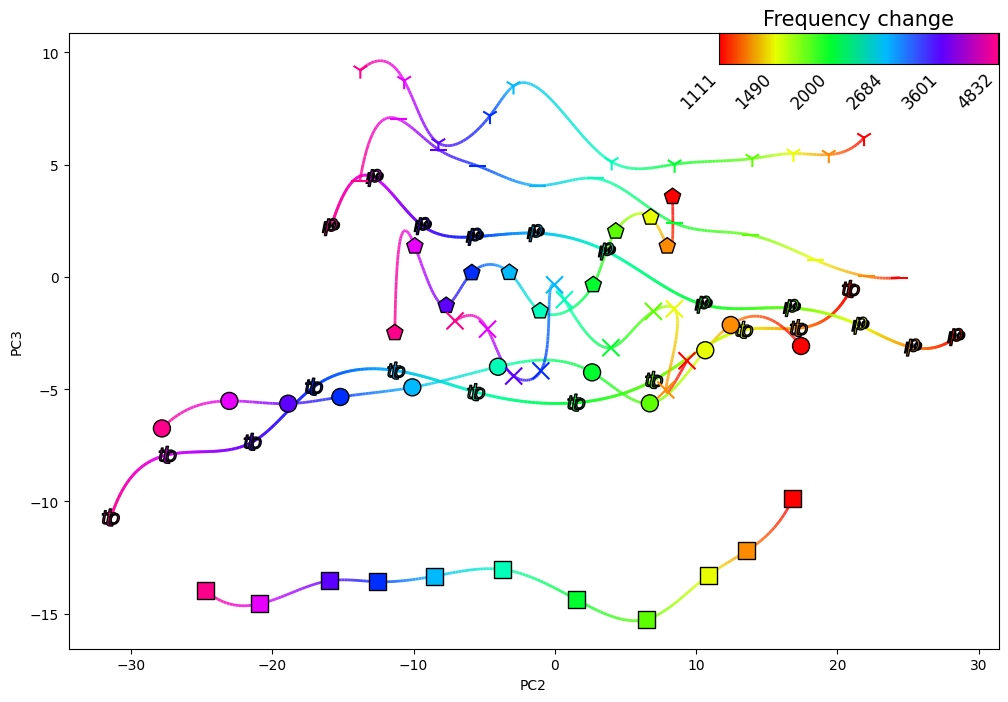

In [ ]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][:,:2],ax,cmaps[i])
"""
comp = [1,2]

colors = get_hsv_colors(len(traj_PC_track_0))
nb_times = len(traj_PC_pb_0[0])

#ax.scatter(traj_track[:,nb_times//3,0],traj_track[:,nb_times//3,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track['label'].to_numpy().astype(int)[::2])


plot_gradient_curve(traj_PC_track[:,nb_times//3,comp],colors, ax, marker = '$t$')
plot_gradient_curve(traj_PC_pb[:,nb_times//3,comp],colors, ax, marker = '$p$')

plot_gradient_curve(traj_PC_track_0[:,nb_times//3,comp],colors, ax)

plot_gradient_curve(traj_PC_pb_0[:,nb_times//3,comp],colors, ax, marker='_')

plot_gradient_curve(traj_PC_track_1[:,nb_times//3,comp],colors, ax, marker='s')
plot_gradient_curve(traj_PC_pb_1[:,nb_times//3,comp],colors, ax, marker='1')

plot_gradient_curve(traj_PC_track_2[:,nb_times//3,comp],colors, ax, marker='p')
plot_gradient_curve(traj_PC_pb_2[:,nb_times//3,comp],colors, ax, marker='x')


ax.set_xlabel(f'PC{comp[0]+1}')
ax.set_ylabel(f'PC{comp[1]+1}')



In [33]:
traj_PC_pb_0

array([[[-10.73327096,  20.74268873,  -6.03212334, ...,  -5.50774853,
          -0.16880541,   0.75333908],
        [-10.59225079,  20.83419701,  -5.99183912, ...,  -5.49780518,
          -0.12822375,   0.74730131],
        [-10.43769373,  20.9376296 ,  -5.92224764, ...,  -5.50667812,
          -0.12204804,   0.75487742],
        ...,
        [-10.10160429,  20.22727792,  -6.13723137, ...,  -3.9882427 ,
          -1.35915743,   0.40104098],
        [-10.22759912,  20.16986433,  -6.37127874, ...,  -4.0424043 ,
          -1.46970241,   0.43225896],
        [-10.32840644,  20.11535425,  -6.5974937 , ...,  -4.10157108,
          -1.55618268,   0.4910185 ]],

       [[-10.80728474,  18.66872228,  -5.22355653, ...,  -3.5818906 ,
          -0.35181917,   2.01222348],
        [-10.68383154,  18.80261844,  -5.24043382, ...,  -3.5812308 ,
          -0.24059458,   2.13545302],
        [-10.60358695,  18.91253224,  -5.22673722, ...,  -3.56322832,
          -0.14590925,   2.25404425],
        ...,


/tmp/ipykernel_104685/3252307892.py:149: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=150, zorder=3)


Text(0, 0.5, 'PC4')

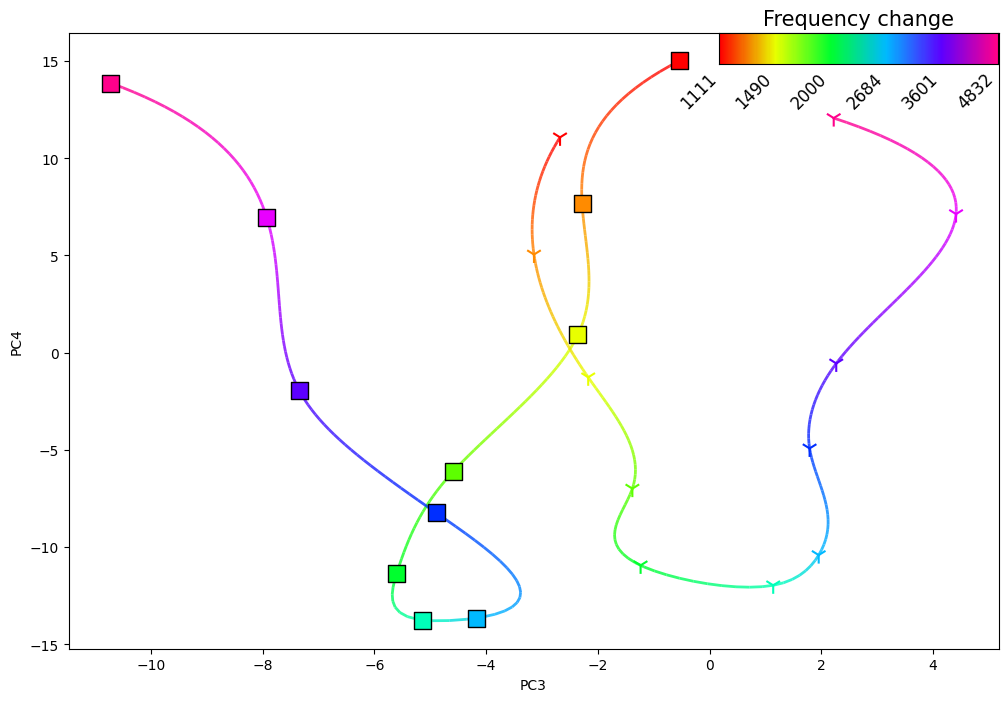

In [43]:
 #comparer la projection de traj_PC_track avec traj_PC_track_original et traj_PC_pb avec traj_PC_pb_original

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][:,:2],ax,cmaps[i])
"""

comp =[2,3]

colors = get_hsv_colors(len(traj_PC_track_0))
nb_times = len(traj_PC_pb_0[0])

#ax.scatter(traj_track[:,nb_times//3,0],traj_track[:,nb_times//3,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track['label'].to_numpy().astype(int)[::2])
#plot_gradient_curve(traj_PC_track_original[:,nb_times//3,comp],colors, ax)

#plot_gradient_curve(traj_PC_pb_original[:,nb_times//3,comp],colors, ax, marker='_')

plot_gradient_curve(traj_PC_track[:,nb_times//3,comp],colors, ax, marker='s')
plot_gradient_curve(traj_PC_pb[:,nb_times//3,comp],colors, ax, marker='1')

ax.set_xlabel(f'PC{comp[0]+1}')
ax.set_ylabel(f'PC{comp[1]+1}')


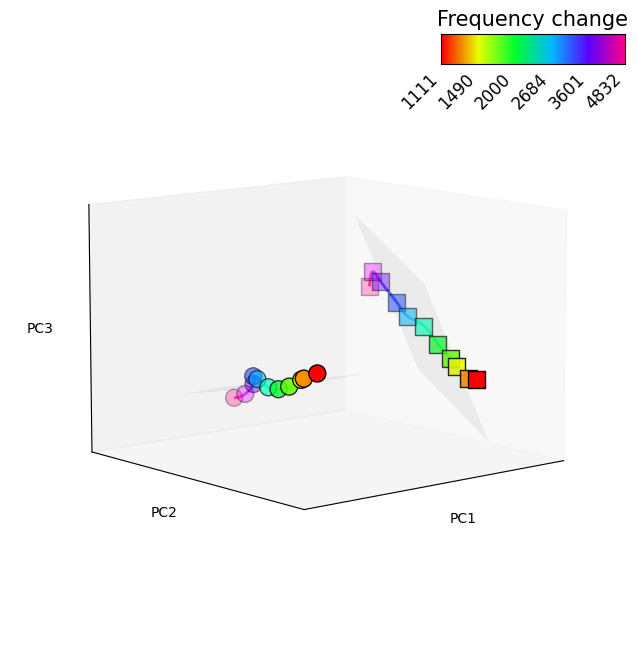

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline



def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(11)

traj_PC_track = traj_PC_track
traj_PC_pb = traj_PC_pb

comps=[0, 1, 2]
#comps=[1, 2, 3]
#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)




ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=50, elev=10)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track['label'].to_numpy().astype(int)[::2])
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

/tmp/ipykernel_104685/3148277837.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


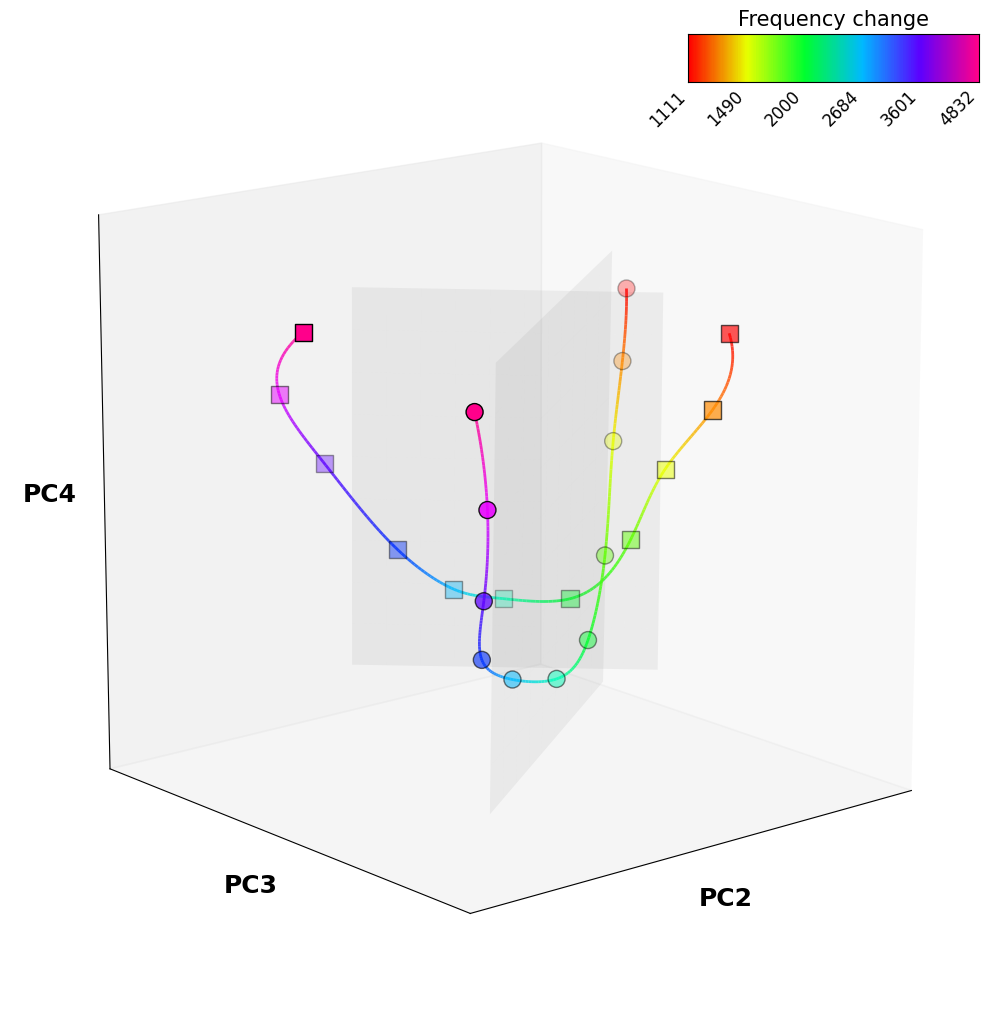

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
save_directory = '/home/felicie/Documents/Figures/'
# --- fonction plane (inchangée) ---
def plot_plane(ax, B, center=None, size=1.0, alpha=0.25, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)

# --- Figure Poster ---
cmaps = create_white_to_color_colormaps(n_colors=16)
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

colors = get_hsv_colors(11)

traj_PC_track = traj_PC_track
traj_PC_pb = traj_PC_pb

comps = [1, 2, 3]  # PC1, PC2, PC3
nb_time = 10     # ou un autre index pertinent

# --- Trajectoires Tracking ---
plane_track = plot_gradient_curve(traj_PC_track[:,nb_time,comps], colors, ax,
                                  show_plane=True)

# --- Trajectoires Playback ---
plane_pb = plot_gradient_curve(traj_PC_pb[:,nb_time,comps], colors, ax,
                               marker='s', show_plane=True)

# --- Axes ---
ax.set_xlabel('PC'+str(comps[0]+1), fontsize=18, fontweight='bold')
ax.set_ylabel('PC'+str(comps[1]+1), fontsize=18, fontweight='bold')
ax.set_zlabel('PC'+str(comps[2]+1), fontsize=18, fontweight='bold')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# --- Aspect cube et vue ---
ax.set_box_aspect([1,1,1])  # proportions égales
ax.view_init(azim=230, elev=15)

# --- Légende Phases ---
add_inset_phase_legend(ax, colors[::2],
                       tick_labels=traj_df_track['label'].to_numpy().astype(int)[::2])

plt.tight_layout()
# Sauvegarde haute résolution pour poster
fig.savefig(save_directory + "PCA234_poster.png", dpi=600, bbox_inches="tight")   # PNG HD
fig.savefig(save_directory + "PCA234_poster.pdf", bbox_inches="tight")       
plt.show()


In [37]:

from scipy.stats import pearsonr, spearmanr

# --- récupérer les labels de fréquence ---
# concatène les labels des 4 DataFrames
freq_labels = np.concatenate([
    traj_df_track['label'].to_numpy(),
    traj_df_track['label'].to_numpy(),
])

# Attention : traj_PC_all est [n_trials, n_time, n_comp]
# On veut corréler les scores moyens par trial avec la fréquence
pc_scores_per_trial = traj_PC_all.mean(axis=1)  # [n_trials, n_comp]

# --- corrélation PC ↔ fréquence ---
results = []
for i in range(pc_scores_per_trial.shape[1]):
    pc_scores = pc_scores_per_trial[:, i]
    r_p, p_p = pearsonr(pc_scores, freq_labels)
    r_s, p_s = spearmanr(pc_scores, freq_labels)
    results.append({
        "PC": i+1,
        "Pearson_r": r_p, "Pearson_p": p_p,
        "Spearman_r": r_s, "Spearman_p": p_s,
    })

df_corr = pd.DataFrame(results)
print(df_corr)


   PC  Pearson_r     Pearson_p  Spearman_r    Spearman_p
0   1  -0.303421  1.698405e-01   -0.496179  1.884097e-02
1   2  -0.926967  5.750584e-10   -0.944779  3.784719e-11
2   3   0.084289  7.091945e-01    0.079298  7.257512e-01
3   4   0.186616  4.056590e-01   -0.022657  9.202823e-01
4   5   0.075302  7.390944e-01    0.074767  7.408863e-01
5   6   0.036834  8.707245e-01   -0.004531  9.840329e-01
6   7   0.090634  6.883289e-01    0.061173  7.868292e-01
7   8  -0.057600  7.990264e-01    0.002266  9.920161e-01
8   9   0.060255  7.899560e-01    0.063438  7.791199e-01
9  10  -0.175353  4.350701e-01   -0.126877  5.736734e-01


In [38]:
import numpy as np

def measure_spread_3D(trajectories):
    """
    trajectories: liste de tableaux [N_points x 3] (PC1, PC2, PC3)
    
    Retourne un dictionnaire par trajectoire avec :
        - range sur chaque PC
        - variance sur chaque PC
        - longueur totale de l'arche
    """
    results = []
    for traj in trajectories:
        range_pc = np.ptp(traj, axis=0)  # max-min sur chaque axe
        var_pc = np.var(traj, axis=0)    # variance sur chaque axe
        
        # longueur totale de l'arche
        diffs = np.diff(traj, axis=0)
        length = np.sum(np.linalg.norm(diffs, axis=1))
        
        results.append({
            'range_PC1': range_pc[0],
            'range_PC2': range_pc[1],
            'range_PC3': range_pc[2],
            'var_PC1': var_pc[0],
            'var_PC2': var_pc[1],
            'var_PC3': var_pc[2],
            'length': length
        })
    return results

# -----------------------------
# Exemple d'utilisation
# -----------------------------
traj_list = [traj_PC_track, traj_PC_pb]
metrics = measure_spread_3D(traj_list)

for label, m in zip(['Tracking', 'Playback'], metrics):
    print(f"Metrics {label}:")
    print(m)


Metrics Tracking:
{'range_PC1': array([22.41160588, 44.80008937,  7.14075123, 22.60281422, 14.69292965,
       12.24219571, 12.02470029, 10.07627824,  9.49221195,  8.83387848]), 'range_PC2': array([22.44892388, 45.0375782 ,  7.44441149, 22.7506602 , 14.73320835,
       12.07556005, 11.91733066, 10.05195647,  9.30257387,  9.04235861]), 'range_PC3': array([22.47986056, 45.26107093,  7.65950585, 22.82350997, 14.66071368,
       11.93172861, 11.73401024, 10.08051432,  9.09818554,  9.20287158]), 'var_PC1': array([ 62.36240007, 220.69164098,   4.85435033,  62.24261812,
        31.03006296,  10.43750211,  11.70621832,  11.02678005,
         7.48062484,   7.84259689]), 'var_PC2': array([ 62.5284271 , 222.55007827,   5.12492825,  63.16699962,
        30.82960495,  10.33127801,  11.66544293,  11.05266697,
         7.39131245,   8.25286619]), 'var_PC3': array([ 62.69298718, 224.32909146,   5.34827575,  64.02730811,
        30.62948717,  10.29143205,  11.60709555,  11.1968058 ,
         7.23591342

NameError: name 'traj_PC_pb_p' is not defined

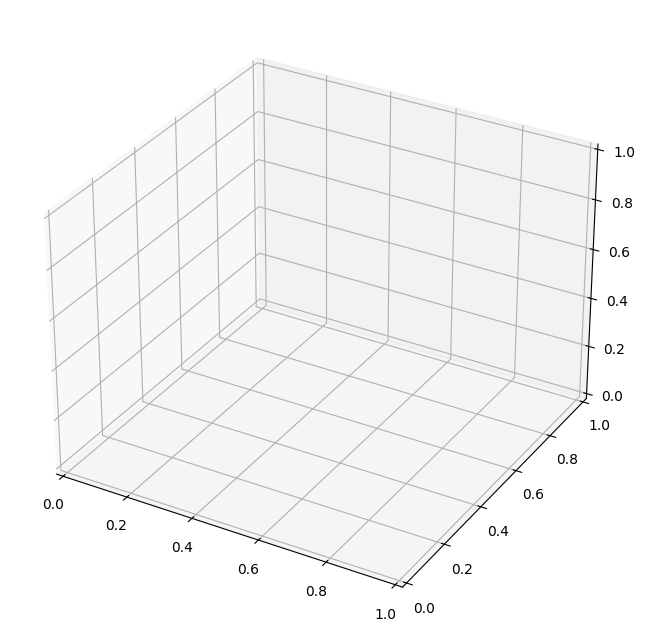

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline


def plot_plane(ax, B, center=None, size=1.0, alpha=0.2, color='cyan'):
    B = np.asarray(B)
    if B.shape != (3, 2):
        raise ValueError("B must be shape (3, 2) — two 3D spanning vectors.")

    if center is None:
        center = np.zeros(3)
    else:
        center = np.asarray(center)
    
    # Define corners of the plane
    v1, v2 = B[:, 0] * size, B[:, 1] * size
    corners = np.array([
        center - v1 - v2,
        center + v1 - v2,
        center + v1 + v2,
        center - v1 + v2
    ])

    # Create the polygon
    poly = Poly3DCollection([corners], alpha=alpha, facecolor=color, edgecolor='none')
    ax.add_collection3d(poly)


cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors(11)

traj_PC_track = traj_PC_pb_p
traj_PC_pb = traj_PC_pb_m

comps=[1,2,3]

#ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,stop_time,1],traj_PC_track[:,stop_time,2],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,stop_time,1],traj_PC_pb[:,stop_time,2],c=colors,s=100)
#plane_track = plot_gradient_curve(traj_PC_track[:,10,comps],colors, ax,show_plane=True)
#plane_pb = plot_gradient_curve(traj_PC_pb[:,10,comps],colors, ax,marker='s',show_plane=True)

plane_track_slow = plot_gradient_curve(traj_PC_track_slow[:,10,comps],colors, ax,show_plane=True)
plane_track_fast = plot_gradient_curve(traj_PC_track_fast[:,10,comps],colors, ax,marker='s',show_plane=True)

plane_pb_slow = plot_gradient_curve(traj_PC_pb_slow[:,10,comps],colors, ax,marker='v',show_plane=True)
plane_pb_fast = plot_gradient_curve(traj_PC_pb_fast[:,10,comps],colors, ax,marker='^',show_plane=True)

#plot_plane(ax, cca_a1[comps,:][:,[0,1]], size=20, alpha=0.1, color='cyan')


ax.set_xlabel('PC'+ str(comps[0]+1))
ax.set_ylabel('PC'+ str(comps[1]+1))
ax.set_zlabel('PC'+ str(comps[2]+1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=180, elev=30)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

In [ ]:
mpl.pyplot.close()

In [ ]:
def vec_alignement(n1,n2) :
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # Dot product clipped to [-1, 1] for numerical safety
    dot = np.clip(np.dot(n1, n2), -1.0, 1.0)
    
    theta = np.arccos(dot)
    theta = min(theta, np.pi - theta)

    return theta*180/np.pi


pca_2d_track = PCA(n_components=2)
pca_2d_pb = PCA(n_components=2)

comps = [[i,i+1,i+2] for i in range(np.shape(traj_PC_track)[2]-2)]

n_freq = len(traj_PC_track)

tonotopy_alignement_pc = []
for comp in comps:
    align_boot = []
    for b in range(100) :
        track_boot = traj_PC_track[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comp]
        pb_boot = traj_PC_pb[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comp]
        
        pca_2d_track.fit(track_boot)
        pca_2d_pb.fit(pb_boot)
    
        n1 = np.cross(pca_2d_track.components_[0], pca_2d_track.components_[1])
        n2 = np.cross(pca_2d_pb.components_[0], pca_2d_pb.components_[1])
        
        align_boot.append(vec_alignement(n1,n2))

    tonotopy_alignement_pc.append(align_boot)

alignement_permu = [vec_alignement(np.random.normal(size = 3),np.random.normal(size = 3)) for _ in range(1000)]

tonotopy_alignement_pc = np.array(tonotopy_alignement_pc)

In [ ]:
from scipy.ndimage import gaussian_filter

plt.plot(gaussian_filter(np.mean(tonotopy_alignement_pc,axis=1),sigma=0))
print(np.percentile(alignement_permu,(10,90)))

In [ ]:
from scipy.ndimage import gaussian_filter

def variance_explained_by_subspace(W, X):
    """
    Compute variance explained by a subspace and its orthogonal complement.

    Parameters
    ----------
    W : ndarray, shape (n_features, n_components)
        CCA weight matrix (columns are subspace basis vectors).
    X : ndarray, shape (n_samples, n_features)
        Data matrix.

    Returns
    -------
    var_in_subspace : float
        Fraction of total variance explained by the CCA subspace.
    var_in_complement : float
        Fraction of total variance in the orthogonal complement.
    """
    Q, _ = np.linalg.qr(W)  # Q spans the same subspace as W

    # Project data into subspace
    X_proj = X @ Q @ Q.T   

    # Residual (orthogonal complement)
    X_resid = X - X_proj

    # Total variance
    total_var = np.sum(np.var(X, axis=0, ddof=1))

    # Variance in subspace
    var_subspace = np.sum(np.var(X_proj, axis=0, ddof=1))
    var_complement = np.sum(np.var(X_resid, axis=0, ddof=1))

    return (var_subspace / total_var) / (var_complement / total_var)



var_com_track = np.array([[variance_explained_by_subspace(cca_a1[:,:5],traj_PC_track[np.random.choice(range(len(traj_PC_track)),len(traj_PC_track)),t,:])\
                           for _ in range(100)] for t in range(np.shape(traj_PC_track)[1])])

var_com_pb = np.array([[variance_explained_by_subspace(cca_a1[:,:5],traj_PC_pb[np.random.choice(range(len(traj_PC_pb)),len(traj_PC_pb)),t,:])\
                           for _ in range(100)] for t in range(np.shape(traj_PC_pb)[1])])


track_CI_up, track_CI_down = np.mean(var_com_track,axis=1) + np.std(var_com_track,axis=1), np.mean(var_com_track,axis=1) - np.std(var_com_track,axis=1)
pb_CI_up, pb_CI_down = np.mean(var_com_pb,axis=1) + np.std(var_com_pb,axis=1), np.mean(var_com_pb,axis=1) - np.std(var_com_pb,axis=1)

fig = plt.figure(figsize=(10,6))

sgm=2
plt.plot(gaussian_filter(np.mean(var_com_track,axis=1),sigma=sgm),color='#FF495C')
plt.plot(gaussian_filter(np.mean(var_com_pb,axis=1),sigma=sgm),color='black')

plt.fill_between(range(len(var_com_track)),gaussian_filter(track_CI_down,sigma=sgm),gaussian_filter(track_CI_up,sigma=sgm),color='#FF495C',alpha=0.1)
plt.fill_between(range(len(var_com_pb)),gaussian_filter(pb_CI_down,sigma=sgm),gaussian_filter(pb_CI_up,sigma=sgm),color='black',alpha=0.1)
plt.axvline(33, linestyle='--',color='grey',linewidth=2)

plt.ylabel('Comm. subspace \n overlap ratio')
plt.xlabel('Time (ms)')
plt.yticks([1,2,3,4,5,6])
plt.xticks([0,16,33,50,66,83,100],[-180,-90,0,90,180,270,360])

plt.savefig('Plots/SVG/overlap_ratio.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/overlap_ratio.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
def vec_alignement(n1,n2) :
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # Dot product clipped to [-1, 1] for numerical safety
    dot = np.clip(np.dot(n1, n2), -1.0, 1.0)
    
    theta = np.arccos(dot)
    theta = min(theta, np.pi - theta)

    return theta*180/np.pi


pca_2d_track = PCA(n_components=2)
pca_2d_pb = PCA(n_components=2)

comps = [0,1,2]

n_freq = len(traj_PC_track)

tonotopy_alignement = []
ctx_n1 = []
ctx_n2 = []
for b in range(100) :
    track_boot = traj_PC_track[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comps]
    pb_boot = traj_PC_pb[np.random.choice(range(n_freq),n_freq,replace=True),-1,:][:,comps]
    
    pca_2d_track.fit(track_boot)
    pca_2d_pb.fit(pb_boot)

    ctx_axis = np.mean(track_boot,axis=0) - np.mean(pb_boot,axis=0)

    n1 = np.cross(pca_2d_track.components_[0], pca_2d_track.components_[1])
    n2 = np.cross(pca_2d_pb.components_[0], pca_2d_pb.components_[1])
    
    tonotopy_alignement.append(vec_alignement(n1,n2))
    ctx_n1.append(vec_alignement(n1,ctx_axis))
    ctx_n2.append(vec_alignement(n2,ctx_axis))

alignement_permu = [vec_alignement(np.random.normal(size = 3),np.random.normal(size = 3)) for _ in range(1000)]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def violinplots(data_list, y_labels=("Tonotopy \n alignement","Context alignement \n with tonotopy orthogonal", "Permutations"),
                         x_label="Angle (°)", palette=("#FF495C", 'orange',"#A2A79E"),
                         figsize=(6,4)):

    # Tidy DataFrame for seaborn
    vals = np.concatenate([np.asarray(list_i, float) for list_i in data_list])
    groups = np.repeat(y_labels, [len(list_i) for list_i in data_list])
    df = pd.DataFrame({"Group": groups, "Value": vals})

    fig, ax = plt.subplots(figsize=figsize)

    # Notched (“conic”) boxplots
    sns.violinplot(data=df, x="Value", y="Group", ax=ax, width=0.6, palette=palette,linecolor='black',
                linewidth=2.5,cut=0,inner="box",bw_adjust=1,orient='h')

    # Labels and cosmetics
    ax.set_xlabel(x_label)
    ax.set_xlim(0, 90)
    ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
    ax.set_ylabel("")
    sns.despine(ax=ax, trim=True)
    
    return fig, ax

violinplots([tonotopy_alignement,ctx_n2,alignement_permu])
ax.set_xlim(0, 90)
plt.show()

#plt.savefig('Plots/SVG/tonotopy_geometry.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_geometry.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
def pairwise_distance(X):
    "X is n_sample times n_features"
    diff = X[:, None, :] - X[None, :, :] 
    D = np.sqrt(np.sum(diff ** 2, axis=-1))
    return D

# --- distance matrices ---
D_track = pairwise_distance(traj_PC_track[:, -1, :])
D_pb    = pairwise_distance(traj_PC_pb[:,   -1, :])

# global colour scale: min & max across BOTH matrices
vmin, vmax = np.min([D_track.min(), D_pb.min()]), np.max([D_track.max(), D_pb.max()])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax+1)   # shared normalisation

# --- plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

im0 = axs[0].imshow(D_track, norm=norm, cmap='plasma')
im1 = axs[1].imshow(D_pb,    norm=norm, cmap='plasma')

axs[0].set_title('Tracking')
axs[1].set_title('Playback')

# single colour-bar for both panels
fig.colorbar(im0, ax=axs.ravel().tolist(), shrink=0.7,orientation='horizontal', location='bottom',label='Euclidean distance')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_upper_triangles(D1, D2,
                             labels=("Matrix 1", "Matrix 2"),
                             palette=('#FF495C', '#546460'),
                             swarm_alpha=.4,
                             ax=None):
    """
    Prettier comparison of the upper-triangle coefficients of two
    distance matrices: notched box + swarm overlay.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # ---------- extract upper triangles ----------
    iu = np.triu_indices_from(D1, k=1)
    vals1, vals2 = D1[iu], D2[iu]

    # ---------- tidy DataFrame for seaborn ----------
    df = (pd.DataFrame({
            'Condition': np.repeat(labels, [len(vals1), len(vals2)]),
            'Distance':  np.concatenate([vals1, vals2])
          })
          .reset_index(drop=True))

    # ---------- figure / axes ----------
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # ---------- style ----------
    #sns.set_theme(style="whitegrid", font_scale=1.2)
    #sns.set_theme() 
    sns.boxplot(data=df, x='Condition', y='Distance',
                palette=palette,
                width=.45,
                notch=True,
                linewidth=2,
                fliersize=0,                # hide default outliers
                boxprops=dict(alpha=.8))
    sns.swarmplot(data=df, x='Condition', y='Distance',
                  color='k', alpha=swarm_alpha, size=4)

    # ---------- axes extras ----------
    ax.set_ylabel("Pairwise distance")
    ax.set_xlabel("")
    ax.set_ylim(0, 2.5)
    sns.despine(trim=True)
    return ax

boxplot_upper_triangles(D_track, D_pb, labels=("Tracking", "Playback"))

#plt.savefig('Plots/SVG/dist_tonotopy.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/dist_tonotopy.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
iu = np.triu_indices_from(D_track, k=1)
vals1, vals2 = D_track[iu], D_pb[iu]

mannwhitneyu(vals1,vals2)

### Frequency change decoding

In [ ]:
np.random.seed(42)

w_size_decoding = 100
n_samples = 300
Xs, Ys = [], []

def sample_events(n_data, triggers, freq, n_samples, w_size):
    """Get sampled event indices, frequencies, and stacked neural data."""
    event_idx = get_event_vicinity(triggers, w_size)
    sampled_idx = np.random.choice(len(event_idx), n_samples, replace=False)
    event_idx = event_idx[sampled_idx]
    event_freq = freq[event_idx[:, 0]]  #Set 0 to have starting frequency
    stacked_data = np.stack([n_data[:, idx] for idx in event_idx])
    return event_freq, stacked_data

for n_data, f_data in zip(n_data_s, f_data_s):
    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    condition = f_data['Condition'].to_numpy()

    trigger_map = {
        ('track', +1): triggers * (condition == 0) * (direc == 1),
        ('track', -1): triggers * (condition == 0) * (direc == -1),
        ('pb',    +1): triggers * (condition == 1) * (direc == 1),
        ('pb',    -1): triggers * (condition == 1) * (direc == -1),
    }

    freqs, data_blocks = [], []
    for (cond, change), trig in trigger_map.items():
        f, d = sample_events(n_data, trig, freq, n_samples, w_size_decoding)
        freqs.append(f)
        data_blocks.append(d)

    # Concatenate data
    Xs.append(np.concatenate(data_blocks, axis=0))

    # Labels
    freq_label = np.concatenate(freqs)
    cond_label = np.concatenate([
        np.full(n_samples * 2, 0),  # track
        np.full(n_samples * 2, 1)   # pb
    ])
    change_label = np.concatenate([
        np.full(n_samples, +1), np.full(n_samples, -1),  # track
        np.full(n_samples, +1), np.full(n_samples, -1)   # pb
    ])
    Ys.append(np.stack((freq_label, change_label, cond_label), axis=1))

X = np.concatenate(Xs, axis=1)
Y = Ys[0]


In [ ]:
X.shape

In [ ]:
with open("Save/PCA_a1_widefreq", "rb") as fp:   # Unpickling
     pca_a1 = pickle.load(fp)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold

def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

def fit_C(X, y):
    """Select best C using cross-validation."""
    candidate_c = np.logspace(-2, 2, num=15)
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=77)
    scores = []
    for c in candidate_c:
        fold_scores = []
        for tr_idx, te_idx in rkf.split(X):
            model = SVC(C=c, kernel='linear')
            model.fit(X[tr_idx], y[tr_idx])
            fold_scores.append(model.score(X[te_idx], y[te_idx]))
        scores.append(np.mean(fold_scores))
    return candidate_c[np.argmax(scores)]

def decode_condition(X_cond, y_cond, pca_all, timestep, t, nb_permu):
    """Train/test SVC for one condition & timepoint with permutation correction."""
    # Prepare data
    X_win = np.mean(X_cond[:, :, t*timestep:(t+1)*timestep], axis=-1)
    X_win = standardize(pca_all.transform(X_win))
    y_target = y_cond[:, 1]  # change label

    # Select best C
    c_best = fit_C(X_win, y_target)

    rkf = RepeatedKFold(n_splits=2, n_repeats=5, random_state=42)
    scores = []
    for tr_idx, te_idx in rkf.split(X_win):
        X_tr, X_te = X_win[tr_idx], X_win[te_idx]
        y_tr, y_te = y_target[tr_idx], y_target[te_idx]

        model = SVC(C=c_best, kernel='linear')
        model.fit(X_tr, y_tr)
        score = model.score(X_te, y_te)

        # Permutation correction
        perm_scores = []
        for _ in range(nb_permu):
            np.random.shuffle(X_tr)
            perm_model = SVC(C=c_best, kernel='linear')
            perm_model.fit(X_tr, y_tr)
            perm_scores.append(perm_model.score(X_te, y_te))

        scores.append(score - np.nanmedian(perm_scores))
    return np.mean(scores)

# ---------------- Main loop ----------------
nb_permu = 10
nb_bootstrap = 20
timestep = 4

track_change_decoding = []
pb_change_decoding = []

for b in tqdm(range(nb_bootstrap)):
    boot_idx = np.random.choice(len(X), len(X), replace=True)
    X_b, Y_b = X[boot_idx], Y[boot_idx]

    track_scores_t = []
    pb_scores_t = []
    n_time_bins = X.shape[-1] // timestep

    for t in range(n_time_bins):
        # Masks
        track_mask = (Y_b[:, 2] == 0) & (1200 <= Y_b[:, 0]) & (Y_b[:, 0] <= 5000)
        pb_mask    = (Y_b[:, 2] == 1) & (1200 <= Y_b[:, 0]) & (Y_b[:, 0] <= 5000)

        track_scores_t.append(decode_condition(X_b[track_mask], Y_b[track_mask], pca_all, timestep, t, nb_permu))
        pb_scores_t.append(decode_condition(X_b[pb_mask],    Y_b[pb_mask],    pca_all, timestep, t, nb_permu))

    track_change_decoding.append(track_scores_t)
    pb_change_decoding.append(pb_scores_t)

track_change_decoding = np.array(track_change_decoding)
pb_change_decoding = np.array(pb_change_decoding)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

timestep = 4

def fit_alpha_ridge(X, y):
    """Select best alpha for Ridge regression via cross-validation."""
    alphas = np.logspace(-2, 2, num=15)
    rkf = RepeatedKFold(n_splits=2, n_repeats=3, random_state=77)
    scores = []
    
    for alpha in alphas:
        fold_scores = []
        for train_idx, test_idx in rkf.split(X):
            model = Ridge(alpha=alpha)
            model.fit(X[train_idx], y[train_idx])
            fold_scores.append(model.score(X[test_idx], y[test_idx]))  # R² score
        scores.append(np.mean(fold_scores))
    
    return alphas[np.argmax(scores)], np.max(scores)  # best alpha and its score

def ridge_encoding_over_time(X_cond, y_target, timestep=timestep, pca=None):
    """
    For each time bin, fit ridge regression to predict y_cond[:,0] from X_cond.
    Return encoding axes and cross-validated scores per bin.
    
    X_cond: (n_trials, n_neurons, n_time)
    y_cond: (n_trials, n_labels)
    timestep: int, number of timepoints per bin
    pca: optional fitted PCA object to transform X_win
    """
    n_bins = X_cond.shape[-1] // timestep
    encoding_axes = []
    cv_scores = []

    mask = (1500 <= y_target[:, 0]) & (y_target[:, 0] <= 4000)
    y_target = y_target[mask,:]
    X_cond = X_cond[mask] 

    for t in tqdm(range(n_bins)):
        # Slice time window and average
        X_win = np.mean(X_cond[:, :, t*timestep:(t+1)*timestep], axis=-1)
        if pca is not None:
            X_win = pca.transform(X_win)
        
        # Find best alpha via CV
        best_alpha, best_score = fit_alpha_ridge(X_win,y_target)
        
        # Fit model with best alpha on full data
        model = Ridge(alpha=best_alpha)
        model.fit(X_win,y_target)
        
        # Normalize coefficients to get encoding axis
        axis = model.coef_ / np.linalg.norm(model.coef_) if np.linalg.norm(model.coef_) > 0 else model.coef_
        
        encoding_axes.append(axis)
        cv_scores.append(best_score)
    
    return encoding_axes, cv_scores

axes_t, scores_t = ridge_encoding_over_time(X,Y[:,0].reshape(-1,1), pca=pca_a1)

In [ ]:
Y[:,0].reshape(-1,1).shape

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(scores_t)
axs[1].imshow(np.corrcoef(axes_t, rowvar=True))

In [ ]:
axes_t[13]

In [ ]:
fig = plt.figure(figsize=(9,7))

"""
track_CI_up, track_CI_down = np.percentile(track_change_decoding,(95,5),axis=0)
pb_CI_up, pb_CI_down = np.percentile(pb_change_decoding,(95,5),axis=0)
diff_CI_up, diff_CI_down = np.percentile(track_change_decoding-pb_change_decoding,(95,5),axis=0)
"""

track_CI_up, track_CI_down = np.mean(track_change_decoding,axis=0) + np.std(track_change_decoding,axis=0), np.mean(track_change_decoding,axis=0) - np.std(track_change_decoding,axis=0)
pb_CI_up, pb_CI_down = np.mean(pb_change_decoding,axis=0) + np.std(pb_change_decoding,axis=0), np.mean(pb_change_decoding,axis=0) - np.std(pb_change_decoding,axis=0)
diff = track_change_decoding - pb_change_decoding
diff_CI_up, diff_CI_down = np.mean(diff,axis=0) + np.std(diff,axis=0), np.mean(diff,axis=0) - np.std(diff,axis=0)

sgm=2
plt.plot(gaussian_filter(np.mean(track_change_decoding,axis=0),sigma=sgm),color='#FF495C',linewidth=3,label='Tracking')
plt.plot(gaussian_filter(np.mean(pb_change_decoding,axis=0),sigma=sgm),color='black',linewidth=3,label='Playback')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(track_CI_down,sigma=sgm), gaussian_filter(track_CI_up,sigma=sgm), alpha=0.05, color='#FF495C')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(pb_CI_down,sigma=sgm), gaussian_filter(pb_CI_up,sigma=sgm), alpha=0.05, color='black')
#axs[1].plot(gaussian_filter(np.mean(track_change_decoding,axis=0) - np.mean(pb_change_decoding,axis=0),sigma=sgm),color='blue')
#axs[1].fill_between(range(w_size_decoding//timestep), gaussian_filter(diff_CI_down,sigma=sgm), gaussian_filter(diff_CI_up,sigma=sgm), alpha=0.05, color='blue')

plt.axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey',linewidth=3)
#axs[1].axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey')

plt.ylim(0,0.2)
plt.ylabel('Decoding of frequency change \n (above chance performance)')
plt.yticks([0,0.05,0.1,0.15,0.2],['+0% \n (chance)','+5%','+10%','+15%','+20%'])

plt.xlabel('Time from frequency change (ms)')
plt.xticks([0,w_size_decoding//(3*timestep),2*w_size_decoding//(3*timestep),w_size_decoding//timestep-1],np.array([(k-1)*w_size_decoding//(3*timestep) for k in range(4)])*5*timestep)
#axs[1].set_ylim(-0.02,0.12)
#axs[1].set_yticks([0,0.02,0.04,0.06,0.08,0.1],['0%','2%','4%','6%','8%','10%'])

plt.legend()

plt.savefig('Plots/SVG/freq_change_decoding.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/freq_change_decoding.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
from scipy.stats import mannwhitneyu

for t in range(np.shape(track_change_decoding)[1]) :
    print(mannwhitneyu(track_change_decoding[:,t],pb_change_decoding[:,t]))